In [202]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '..')

from sim.LoadBalancer import LoadBalancer
from sim.Source import ArrivalSchedule, Source
from sim.Environment import Environment
import numpy as np
import random
import matplotlib.pyplot as plt
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Implementing the Epsilon Greedy algorithm in our LoadBalancer structure
We use the LoadBalancer as the base class and import the epsilong greedy algorithm

In [203]:
class GreedyEpsilonLoadBalancer(LoadBalancer):
    def __init__(self, nServers, environment, model, processReward=1, cancelReward=10, serverReward=-300, eta=0.15, nServerRange = (1,40), usePartialFit=False):
        """
            model: obj with methods predict, fit, fit_partial etc.
            eta: float or callable(periodIndex: int -> float)
        """
        super().__init__(nServers, environment)
        self.model = model # a model that takes (N_t, X_t) and predicts the reward of the next time period
        self.agg = {'totalInQueue': np.mean,'requestStartWaiting':np.sum,'arrivalEvent':np.sum,'requestWaitingTime': np.mean,'requestProcessed':np.sum,'totalTimeInSystem':np.mean,'requestCancelled':np.sum}
        self.currentPeriod = 0
        self.processReward, self.cancelReward, self.serverReward = processReward, cancelReward, serverReward
        self.eta = eta
        self.nServerRange = nServerRange #the range for the bernoulli to sample from
        self.usePartialFit = usePartialFit
        self.X = None #store the complete feature dataset here
        self.y = None #store the complete target dataset here 

    def getEta(self):
        if callable(self.eta):
            return self.eta(self.currentPeriod)
        else:
            return self.eta

    def getPreviousPeriodContext(self):
        """
        Get the context from the period that just ended (potentially add lags here from previous periods)
        """
        previousPeriodData = self.environment.getPeriodLog() #returns {key: values}
        previousPeriodContext = {key: self.agg[key](vals) for key,vals in previousPeriodData.items() if key in self.agg.keys()} #apply aggregation: go from lists to scalars
        previousPeriodContext ={key:val if not np.isnan(val) else 0 for key,val in previousPeriodContext.items()}
        previousPeriodContext ={key:previousPeriodContext[key] if key in previousPeriodContext.keys() else 0 for key in self.agg.keys()}

        self.environment.resetPeriod()
        return previousPeriodContext

    def getPreviousPeriodReward(self, context: dict):
        """
        Get the reward of the period that just ended
        """
        nProcessed = context['requestProcessed']
        nCancelled = context['requestCancelled'] if 'requestCancelled' in context.keys() else 0
        nServers = self.nServers
        reward = nProcessed * self.processReward + nCancelled * self.cancelReward + nServers * self.serverReward
        return reward

    def findModelOptimum(self, context):
        max = -math.inf
        maxArg = 0
        for n in range(self.nServerRange[0], self.nServerRange[1]): #implement better optimization here
            X =  np.append(np.array(list(context.values())), n)
            rewardHat = self.model.predict(X[None,:])[0]
            if rewardHat > max:
                maxArg = n
                max = rewardHat
        print("Max reward for", rewardHat, maxArg)
        return maxArg

    def getNextPeriodNumberOfServers(self, context):
        #take random action or input the context into the model and maximizy the output w.r.t N
        draw = random.randint(0,1)
        eta = self.getEta()
        nServers = None
        if draw < eta or self.currentPeriod <= 1: #on first iteration the model is not fitted
            #Take random action
            self.environment.logData("greedyEpsilonActionType", 0)
            nServers = random.randint(self.nServerRange[0], self.nServerRange[1])
        else:
            self.environment.logData("greedyEpsilonActionType", 1)
            nServers = self.findModelOptimum(context) 

        return nServers
        
    def updateModel(self, context, reward):
        #update the model using the context, nServers and observed reward
        if self.currentPeriod > 0:
            newY = np.array([reward])
            self.y = np.append(self.y, newY[None,:], axis=0) if self.y is not None else newY[None,:]
            if not self.usePartialFit:
                #print(self.X.shape,self.y.shape)
                self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored
                print(self.model.score(self.X, self.y))
            else:
                raise NotImplementedError

    def updateX(self, context, nOptimal):
        newX = np.array(list(context.values()) + [nOptimal]) #+ [reward] #add the current nServers to X
        self.X = np.append(self.X, newX[None,:], axis=0) if self.X is not None else newX[None,:] #update the data 

    def onPeriodEnd(self):
        #Get the reward of the current period
        previousPeriodContext = self.getPreviousPeriodContext()
        #print(previousPeriodContext)
        previousPeriodReward = self.getPreviousPeriodReward(previousPeriodContext)
        self.environment.logData("reward", previousPeriodReward)
        self.updateModel(previousPeriodContext, previousPeriodReward)
        if self.currentPeriod>0:print(self.X.shape,self.y.shape)
        nextPeriodNServers = self.getNextPeriodNumberOfServers(previousPeriodContext)
        self._setNumberOfServers(nextPeriodNServers)
        self.updateX(previousPeriodContext, nextPeriodNServers)
        self.currentPeriod+=1
        print(self.nServers)



### Test

In [253]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

stopTime = 10*60*60
env = Environment(stopTime=stopTime)

model = LinearRegression()
#model = DecisionTreeRegressor()
loadBalancer = GreedyEpsilonLoadBalancer(nServers=10, environment=env, model = model, eta=lambda t: sigmoid(2/(0.1*t+2)-0.5), nServerRange=[5,40])

requestTypes = [(0.5,2,0.1,10), (0.5,3,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 14
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

schedule = np.array([11,12,14,16,14,30,13,15,17,16,14,12]) #12 periods
periodLength = 0.5*60*60 #half an hour per period -> schedule repeated two times in 12 hours
arrivalSchedule = ArrivalSchedule(periodLength,arrivalSchedule=schedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

27


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan
(1, 8) (1, 1)
16
1.0
(2, 8) (2, 1)
Max reward for [78822.63991913] 5
5
1.0
(3, 8) (3, 1)
10
1.0
(4, 8) (4, 1)
Max reward for [117806.24651682] 5
5
1.0
(5, 8) (5, 1)
Max reward for [690597.03230593] 39
39
1.0
(6, 8) (6, 1)
27
1.0
(7, 8) (7, 1)
33
1.0
(8, 8) (8, 1)
Max reward for [46412.31740264] 39
39
0.9962966801246428
(9, 8) (9, 1)
14
0.9958813824295172
(10, 8) (10, 1)
Max reward for [137401.6065996] 39
39
0.8102375228841412
(11, 8) (11, 1)
Max reward for [-933.12810167] 5
5
0.8087613688399383
(12, 8) (12, 1)
Max reward for [34699.89000705] 5
5
0.7812263992565774
(13, 8) (13, 1)
Max reward for [27215.04429385] 5
5
0.7782950700138802
(14, 8) (14, 1)
20
0.7591667059444479
(15, 8) (15, 1)
28
0.7432848550796338
(16, 8) (16, 1)
28
0.664634605317623
(17, 8) (17, 1)
33
0.633689137888694
(18, 8) (18, 1)
25
0.5433437915426914
(19, 8) (19, 1)
8


(array([41317., 54002., 79063., 50386., 59651., 46899., 41386., 53871.,
        78977., 50374.]),
 array([2.08399651e+00, 3.60186129e+03, 7.20163858e+03, 1.08014159e+04,
        1.44011932e+04, 1.80009705e+04, 2.16007478e+04, 2.52005251e+04,
        2.88003023e+04, 3.24000796e+04, 3.59998569e+04]),
 <a list of 10 Patch objects>)

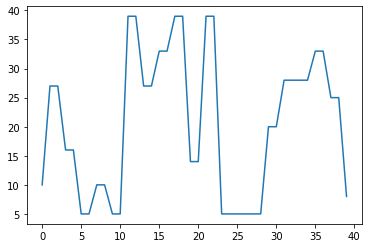

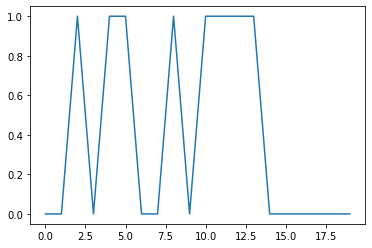

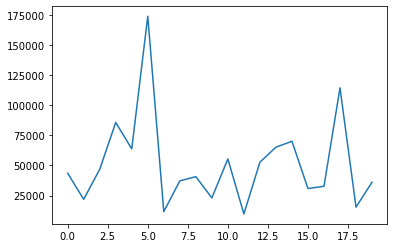

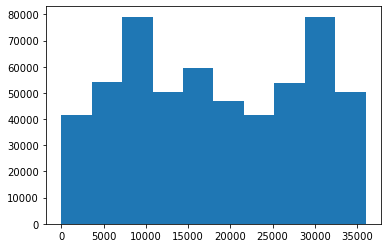

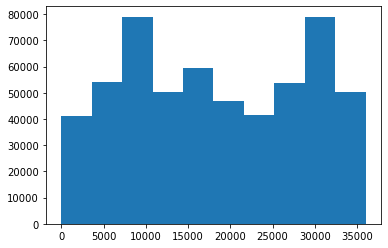

In [254]:
plt.plot(env.log['numberOfServers'])
plt.figure()
plt.plot(env.log['greedyEpsilonActionType'])
plt.figure()
plt.plot(env.log['reward'])
plt.figure()
plt.hist(env.logTime['arrivalEvent'], bins=int(stopTime/60/60))
plt.figure()
plt.hist(env.logTime['requestProcessed'], bins=int(stopTime/60/60))

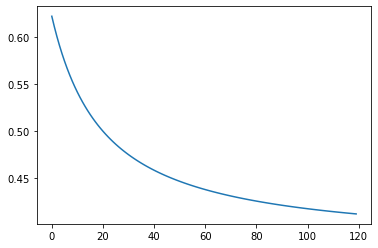

In [250]:

def sigmoid(x):
      return 1 / (1 + np.exp(-x))

x = np.arange(0,120,1)
plt.plot(x, sigmoid(2/(0.1*x+2)-0.5))